In [112]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

spark = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .appName("SimpleApp") \
    .getOrCreate()



### Reading data

In [113]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("trip_fare.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("trip_data.parquet")

In [114]:
df_fare = df_fare.where(F.col("pickup_datetime") <= F.lit("2013-01-27"))
df_trip = df_trip.where(F.col("pickup_datetime") <= F.lit("2013-01-27"))

In [115]:
df_fare.show(3)

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|6C1903A982854FE75...|7A8D37CC21273D13E...|      CMT|2013-01-18 21:23:18|         CRD|       19.0|      0.5|    0.5|       2.5|         0.0|        22.5|
|E245A2E55C81F0BEB...|9D1776576BCA0953B...|      CMT|2013-01-18 20:59:53|         CRD|       13.5|      0.5|    0.5|       1.5|         0.0|        16.0|
|5E7022BA90EE0AFE3...|108CE84A25C9E3CFF...|      CMT|2013-01-18 21:14:34|         CRD|       31.0|      0.5|    0.5|      7.36|         4.8|       44.16|
+--------------------+--------------------+---------+-------------------+---

In [116]:
df_trip.show(3)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|8B650C19E9FAEBD67...|FD9AB389D3ECC80D3...|      CMT|        1|                 N|2013-01-06 00:50:21|2013-01-06 00:54:32|              1|              251|          0.6|      -73.989563|      40.719044|       -73.991646|       40.726589|
|8B650C19E9FAEBD67...|FD9AB389D3ECC80D3...| 

### General Statistical Analysis
Finding <i>mean, standard deviation, median, min and max</i> for each of the numeric attributes in both fare and trip datasets.

In [117]:
def get_stats(df, col_name):
    return df.select(
        F.lit(col_name).alias("feature"),
        F.mean(col_name).alias("mean"),
        F.stddev(col_name).alias("stddev"),
        F.min(col_name).alias("min"),
        F.expr(f'percentile_approx({col_name}, 0.5)').alias("median"),
        F.max(col_name).alias("max")
    )

columns = ["fare_amount", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

df_stats_list = [get_stats(df_fare, col) for col in columns]

df_stats = df_stats_list[0]
for df in df_stats_list[1:]:
    df_stats = df_stats.unionByName(df)

df_stats.show()

+------------+-------------------+-------------------+---+------+-----+
|     feature|               mean|             stddev|min|median|  max|
+------------+-------------------+-------------------+---+------+-----+
| fare_amount|  11.64940979357973|  9.641581783018069|2.5|   9.0|500.0|
|   surcharge| 0.3172875587999275| 0.3645750108531388|0.0|   0.0| 12.5|
|     mta_tax|0.49838722278647724|0.02835114850282505|0.0|   0.5|  0.5|
|  tip_amount| 1.2510306253790024| 2.0368872562025806|0.0|   0.5|200.0|
|tolls_amount| 0.2012416766994943|  1.033849434797973|0.0|   0.0| 20.0|
|total_amount| 13.917356877242494| 11.448364426974457|2.5|  10.5|650.0|
+------------+-------------------+-------------------+---+------+-----+



In [118]:
columns = ["trip_time_in_secs", "trip_distance", "passenger_count"]

df_stats_list = [get_stats(df_trip, col) for col in columns]
for df in df_stats_list[0:]:
    df_stats = df_stats.unionByName(df)

df_stats.show()

+-----------------+-------------------+-------------------+---+------+-------+
|          feature|               mean|             stddev|min|median|    max|
+-----------------+-------------------+-------------------+---+------+-------+
|      fare_amount|  11.64940979357973|  9.641581783018069|2.5|   9.0|  500.0|
|        surcharge| 0.3172875587999275| 0.3645750108531388|0.0|   0.0|   12.5|
|          mta_tax|0.49838722278647724|0.02835114850282505|0.0|   0.5|    0.5|
|       tip_amount| 1.2510306253790024| 2.0368872562025806|0.0|   0.5|  200.0|
|     tolls_amount| 0.2012416766994943|  1.033849434797973|0.0|   0.0|   20.0|
|     total_amount| 13.917356877242494| 11.448364426974457|2.5|  10.5|  650.0|
|trip_time_in_secs|  679.5346706257795|  490.6151931029789|0.0| 549.0|10800.0|
|    trip_distance| 2.7736331848585616|  3.314625055934318|0.0|   1.7|  100.0|
|  passenger_count| 1.7026158840398544| 1.3668410370075714|0.0|   1.0|  255.0|
+-----------------+-------------------+-------------

In [119]:
df_stats.coalesce(1).write.csv("df_stats.csv")

### Passenger Count
Taking a look at the count of trips with different passenger counts.

In [120]:
df_passenger_count = df_trip.select("passenger_count").groupBy("passenger_count").count().toPandas()
df_passenger_count.sort_values('passenger_count', inplace=True)
df_passenger_count['passenger_count'] = df_passenger_count['passenger_count'].astype(str)

/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_7851/331447125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='passenger_count', y='count', data=df_passenger_count, palette="Blues_d")


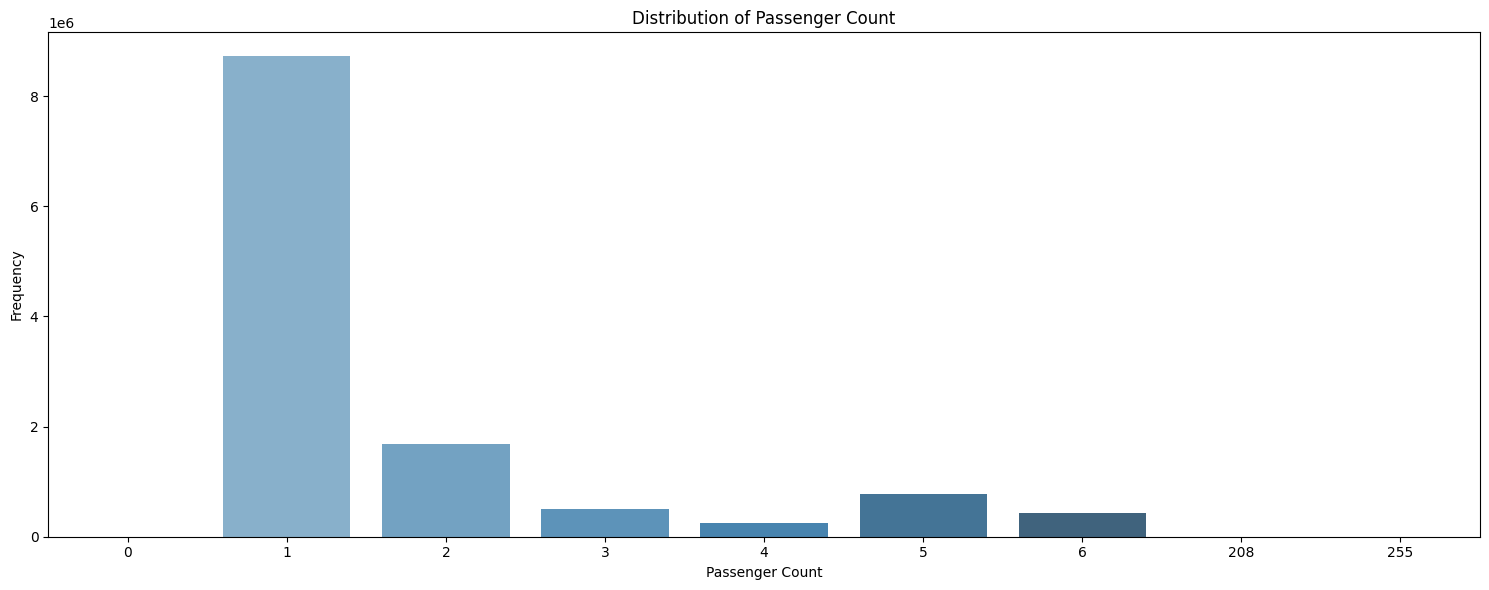

In [121]:
plt.figure(figsize=(15, 6))
sns.barplot(x='passenger_count', y='count', data=df_passenger_count, palette="Blues_d")
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Total Amount
Finding how many negative and positive values are out there.

In [122]:
df_fare.where(df_fare['total_amount'] > 0).count(), df_fare.where(df_fare['total_amount'] <= 0).count()

(12364386, 0)

### Rate Code
Calculating how many rate codes does the dataset contain. Observing how the data of this attribute looks like.

In [123]:
df_trip[['rate_code']].distinct().count()

13

In [124]:
df_trip[['rate_code']].distinct().show(26)

+---------+
|rate_code|
+---------+
|      210|
|       28|
|        1|
|        6|
|        3|
|        5|
|        9|
|        4|
|        2|
|        0|
|        7|
|        8|
|      128|
+---------+



### Payment Types
Find what payment types exist in the dataset. Find the frequency of payment types. 

In [125]:
df_fare.select("payment_type").distinct().show()

+------------+
|payment_type|
+------------+
|         CSH|
|         DIS|
|         CRD|
|         UNK|
|         NOC|
+------------+



In [126]:
df_payment_type_count = df_fare.select("payment_type").repartition(100).groupBy("payment_type").count().toPandas()

In [127]:
df_payment_type_count.sort_values("count", inplace=True, ascending=False)

/var/folders/vz/rgbmjfqn0nq0nvl3m3c5by_00000gn/T/ipykernel_7851/919329884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_type', y='count', data=df_payment_type_count, palette="Blues_d")


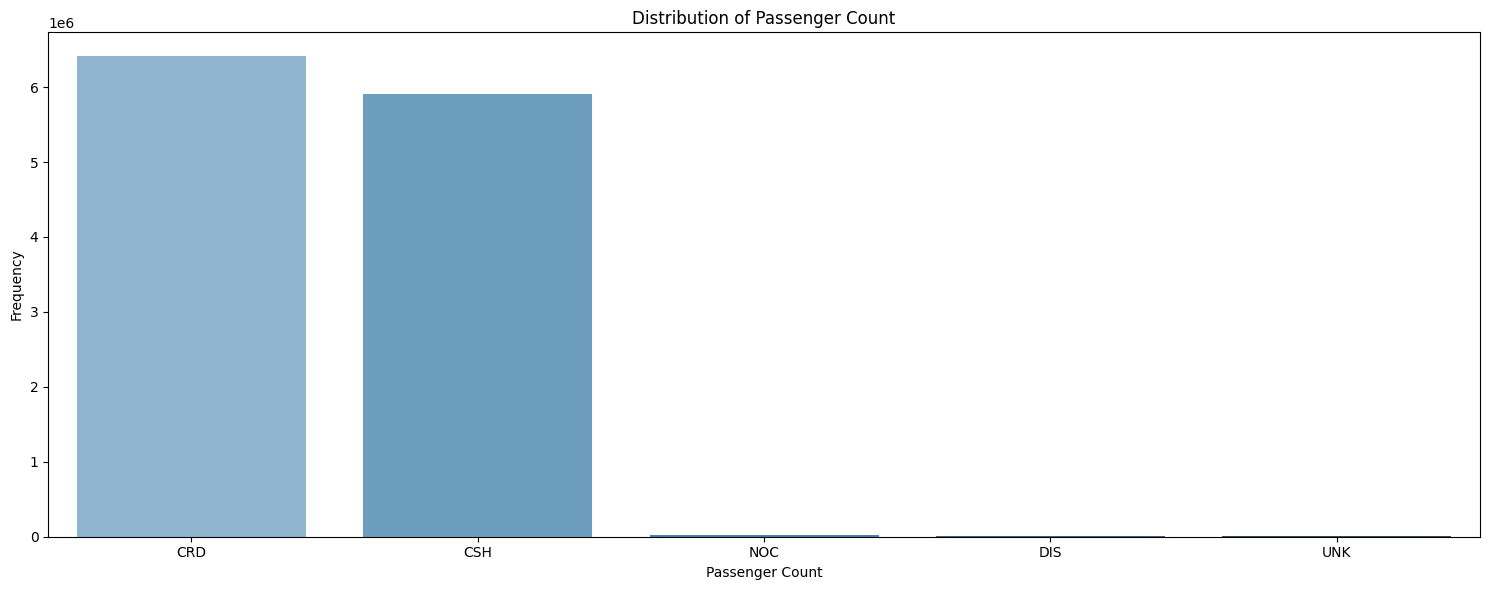

In [128]:
plt.figure(figsize=(15, 6))
sns.barplot(x='payment_type', y='count', data=df_payment_type_count, palette="Blues_d")
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [129]:
df_payment_type_count

,payment_type,count
2,CRD,6410836
0,CSH,5910912
4,NOC,27728
1,DIS,9619
3,UNK,5291


In [130]:
card_count = df_payment_type_count[df_payment_type_count['payment_type'] == 'CRD']['count'].iloc[0]
cash_count = df_payment_type_count[df_payment_type_count['payment_type'] == 'CSH']['count'].iloc[0]
total = card_count + cash_count
card_percent = card_count / total * 100
cash_percent = cash_count / total * 100

print(f"Card: {round(card_percent, 2)}%")
print(f"Cash: {round(cash_percent, 2)}%")

Card: 52.03%
Cash: 47.97%


### MTA TAX

In [131]:
df_mta_tax = df_fare.select("mta_tax").groupby("mta_tax").count().sort("mta_tax")
df_mta_tax.show()

+-------+--------+
|mta_tax|   count|
+-------+--------+
|    0.0|   39882|
|    0.5|12324504|
+-------+--------+



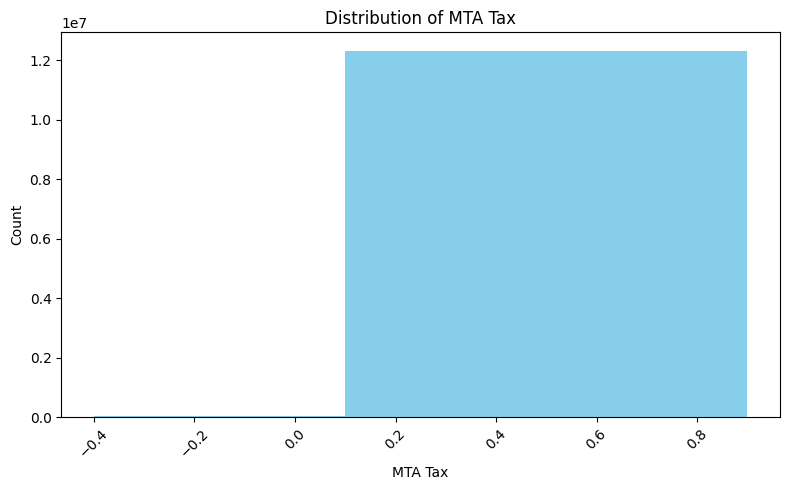

In [132]:
pdf = df_mta_tax.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(pdf['mta_tax'], pdf['count'], color='skyblue')
plt.xlabel('MTA Tax')
plt.ylabel('Count')
plt.title('Distribution of MTA Tax')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()